# Bradley-Terry Modeling of NBA Teams

In this notebook we'll use a dataset of all games in NBA history from [Kaggle](https://www.kaggle.com/datasets/eoinamoore/historical-nba-data-and-player-box-scores). We'll show how to load general competition or paired comparison datasets using Arena-Rank and compute Bradley-Terry based leaderboards.

Steps:
1. Download and process the dataset.
2. Compute ratings and confidence intervals using Arena-Rank.
3. Analyze the leaderboards for all time, and for the 2025/2026 season.

In [1]:
import kagglehub
import pandas as pd

from arena_rank.utils.data_utils import PairDataset
from arena_rank.models.bradley_terry import BradleyTerry
from example_utils import plot_leaderboard

### Preprocessing
In order to use a dataset with Arena-Rank, we need to process it into the required format where the df must have:
* Two columns which identify the competitors of each match. For this we will map team ids, found in the `hometeamId` and `awayteamId` columns, to the names most recently used by those teams. (Many teams have renamed over time.)
* A column which represents the outcome of the game. The original dataset has a column `winner` which contains the id of the winning team. We map that to a column that contains either `"home"` or `"away"`.

That's enough to get started with Arena-Rank!

In [2]:
path = kagglehub.dataset_download("eoinamoore/historical-nba-data-and-player-box-scores")
df = pd.read_csv(f"{path}/Games.csv", low_memory=False)


def get_team_id_to_name_mapping(df):
    # map team_id to most recent team_name from home/away columns
    home = df[["gameDateTimeEst", "hometeamId", "hometeamName"]].rename(
        columns={"hometeamId": "team_id", "hometeamName": "team_name"}
    )
    away = df[["gameDateTimeEst", "awayteamId", "awayteamName"]].rename(
        columns={"awayteamId": "team_id", "awayteamName": "team_name"}
    )
    all_teams = pd.concat([home, away]).sort_values("gameDateTimeEst").drop_duplicates(subset="team_id", keep="last")
    return dict(zip(all_teams["team_id"], all_teams["team_name"]))


id_to_name = get_team_id_to_name_mapping(df)
df["home"] = df["hometeamId"].map(id_to_name)
df["away"] = df["awayteamId"].map(id_to_name)
df["winner"] = df.apply(lambda row: "home" if row["winner"] == row["hometeamId"] else "away", axis=1)
df = df[["gameDateTimeEst", "home", "away", "winner"]]
df

,gameDateTimeEst,home,away,winner
0,2025-12-21 17:00:00,Kings,Rockets,home
1,2025-12-21 14:00:00,Timberwolves,Bucks,home
2,2025-12-21 14:00:00,Wizards,Spurs,away
3,2025-12-21 13:00:00,Knicks,Heat,home
4,2025-12-21 13:00:00,Nets,Raptors,home
...,...,...,...,...
72368,1946-12-08 19:00:00,Knicks,Celtics,home
72369,1946-12-07 19:00:00,Celtics,Knicks,away
72370,1946-12-05 19:00:00,Warriors,Knicks,home
72371,1946-11-30 19:00:00,Knicks,Warriors,home


### Modeling
To compute the leaderboard we:
1. Create a `PairDataset` object from the dataframe, specifying the columns we created, and how to the values of "winner" column map to outcomes. We represent a home win as 1.0, and an away win as 0.0. (Note there are no ties in basketball.)
2. Create the `BradleyTerry` model object
3. Fit the model on the dataset using `compute_ratings_and_cis`



In [3]:
dataset = PairDataset.from_pandas(
    df,
    competitor_cols=["home", "away"],
    outcome_col="winner",
    outcome_map=lambda x: 1.0 if x == "home" else 0.0,
    reweighted=False,
)

model = BradleyTerry(n_competitors=dataset.n_competitors, init_rating=1200)

# compute ratings and 95% confidence intervals
results = model.compute_ratings_and_cis(dataset, significance_level=0.05)
competitors = dataset.competitors

### Leaderboard Visualization
We can plot the ratings and confidence intervals and recover a ranking of teams using all 72,000 games from NBA history.

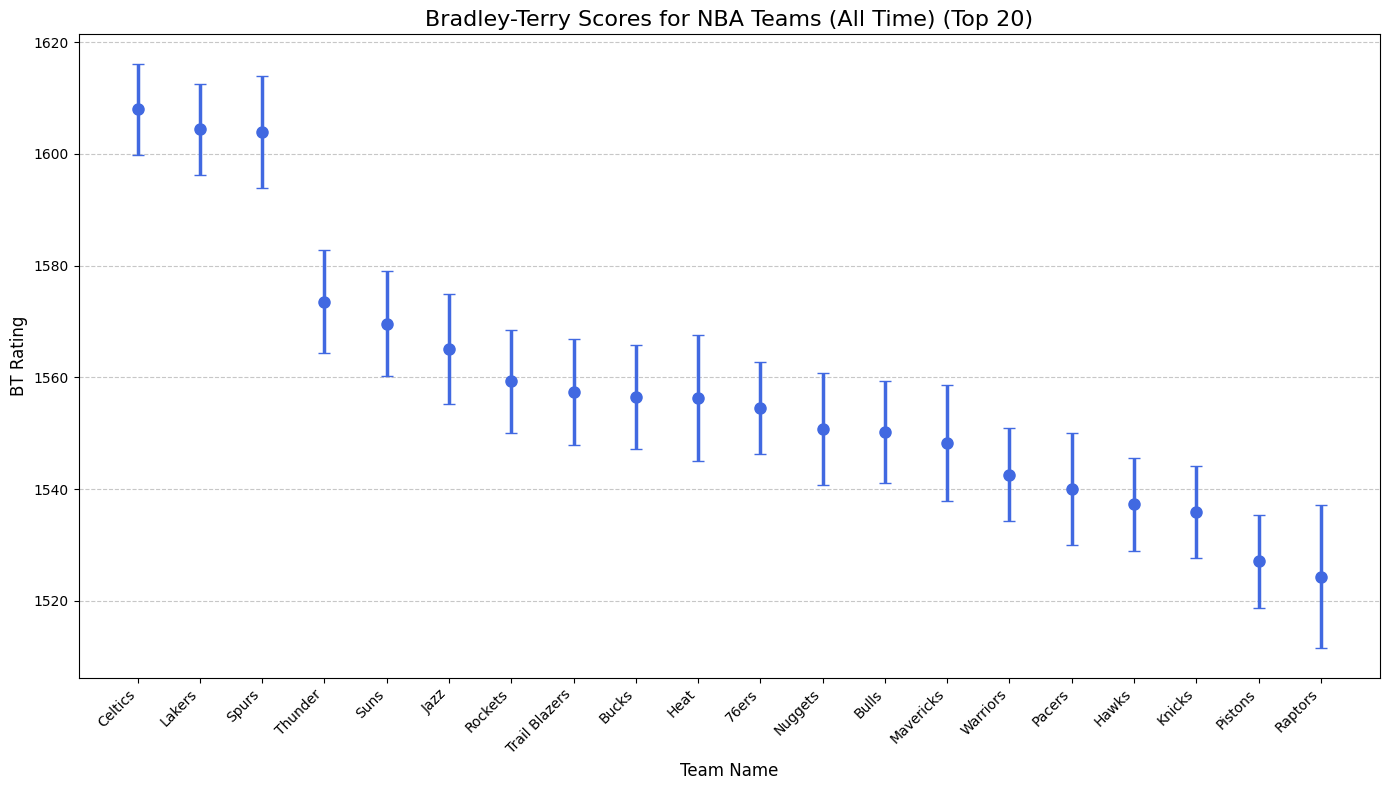

In [4]:
plot_leaderboard(
    results,
    top_n=20,
    title="Bradley-Terry Scores for NBA Teams (All Time)",
    item_name="Team",
    rating_name="BT Rating",
)

### Results
The Celtics, Lakers, and Spurs being the clear top 3 does accurately reflect NBA history. However, team strengths have changed massively over the 80-year history of the NBA, while the Bradley-Terry model assumes competitor strengths are stationary over time. Let's look at just the 2025-2026 season next.

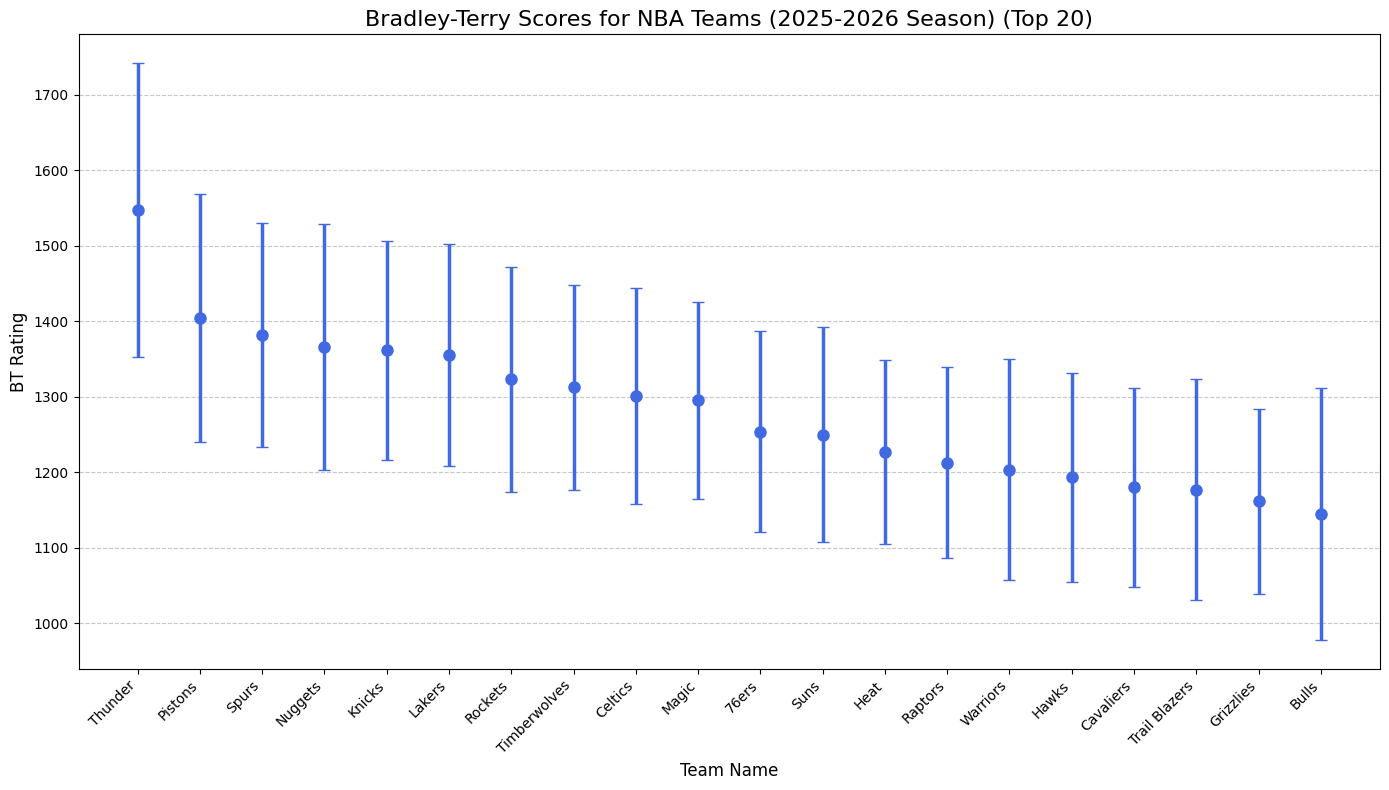

In [5]:
# look at just the last season
recent_df = df[(df["gameDateTimeEst"].str[:10] >= "2025-10-20") & (df["gameDateTimeEst"].str[:10] <= "2026-10-01")]
recent_dataset = PairDataset.from_pandas(
    recent_df,
    competitor_cols=["home", "away"],
    outcome_col="winner",
    outcome_map=lambda x: 1.0 if x == "home" else 0.0,
    reweighted=False,
)
recent_model = BradleyTerry(
    n_competitors=recent_dataset.n_competitors,
    init_rating=1200,
)
recent_results = recent_model.compute_ratings_and_cis(recent_dataset, significance_level=0.05)
plot_leaderboard(
    recent_results,
    top_n=20,
    title="Bradley-Terry Scores for NBA Teams (2025-2026 Season)",
    item_name="Team",
    rating_name="BT Rating",
)

As of December 17th 2025, the Thunder are 24-2 so their large lead makes sense.